# Extensions to Linear Models - Lab

## Introduction

In this lab, you'll practice many concepts you have learned so far, from adding interactions and polynomials to your model to AIC and BIC!

## Summary

You will be able to:
- Build a linear regression model with interactions and polynomial features 
- Use AIC and BIC to select the best value for the regularization parameter 


## Let's get started!

Import all the necessary packages.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from itertools import combinations

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures

Load the data.

In [18]:
df = pd.read_csv("ames.csv")

In [19]:
df = df[['LotArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF',
         '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd',
         'GarageArea', 'Fireplaces', 'SalePrice']]

## Look at a baseline housing data model

Above, we imported the Ames housing data and grabbed a subset of the data to use in this analysis.

Next steps:

- Split the data into target (`y`) and predictors (`X`) -- ensure these both are DataFrames 
- Scale all the predictors using `scale`. Convert these scaled features into a DataFrame 
- Build at a baseline model using *scaled variables* as predictors. Use 5-fold cross-validation (set `random_state` to 1) and use the $R^2$ score to evaluate the model 

In [20]:
# Your code here
y = df['SalePrice']
X = df.drop(columns = 'SalePrice')

In [21]:
X_scaled = scale(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

all_data = pd.concat([y, X_scaled], axis = 1)
all_data.head()

,SalePrice,LotArea,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea,Fireplaces
0,208500,-0.207142,0.651479,-0.517200,-0.459303,-0.793434,1.161852,0.370333,0.912210,0.351000,-0.951226
1,181500,-0.091886,-0.071836,2.179628,0.466465,0.257140,-0.795163,-0.482512,-0.318683,-0.060731,0.600495
2,223500,0.073480,0.651479,-0.517200,-0.313369,-0.627826,1.189351,0.515013,-0.318683,0.631726,0.600495
3,140000,-0.096897,0.651479,-0.517200,-0.687324,-0.521734,0.937276,0.383659,0.296763,0.790804,0.600495
4,250000,0.375148,1.374795,-0.517200,0.199680,-0.045611,1.617877,1.299326,1.527656,1.698485,0.600495


In [22]:
regression = LinearRegression()

crossvalidation = KFold(n_splits = 5, shuffle = True, random_state = 1)
baseline = np.mean(cross_val_score(regression, X_scaled, y, scoring = 'r2', cv = crossvalidation))
baseline           

0.7524751004088885

## Include interactions

Look at all the possible combinations of variables for interactions by adding interactions one by one to the baseline model. Next, evaluate that model using 5-fold cross-validation and store the $R^2$ to compare it with the baseline model.

Print the 7 most important interactions.

In [23]:
combinations = list(combinations(X.columns, 2))

interactions = []
data = X_scaled.copy()
for comb in combinations:
    data['interaction'] = data[comb[0]] * data[comb[1]]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    if score > baseline: interactions.append((comb[0], comb[1], round(score, 3)))
            
print('Top 7 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:7])

Top 7 interactions: [('OverallQual', 'TotRmsAbvGrd', 0.77), ('OverallQual', 'GarageArea', 0.764), ('OverallQual', '2ndFlrSF', 0.758), ('2ndFlrSF', 'GrLivArea', 0.756), ('2ndFlrSF', 'TotRmsAbvGrd', 0.756), ('OverallQual', 'Fireplaces', 0.754), ('OverallCond', 'TotalBsmtSF', 0.754)]


Write code to include the 7 most important interactions in your data set by adding 7 columns. Name the columns "var1_var2", where var1 and var2 are the two variables in the interaction.

In [24]:
# Your code here
df_inter = X_scaled.copy()
ls_interactions = sorted(interactions, key = lambda inter: inter[2], reverse = True)[:7]
for inter in ls_interactions:
    df_inter[inter[0] + '_' + inter[1]] = X[inter[0]] * X[inter[1]]


## Include polynomials

Try polynomials of degrees 2, 3, and 4 for each variable, in a similar way you did for interactions (by looking at your baseline model and seeing how $R^2$ increases). Do understand that when going for a polynomial of 4, the particular column is raised to the power of 2 and 3 as well in other terms. We only want to include "pure" polynomials, so make sure no interactions are included. We want the result to return a list that contain tuples of the form:

`(var_name, degree, R2)`, so eg. `('OverallQual', 2, 0.781)` 

In [25]:
# Your code here
polynomials = []
for col in X.columns:
    for degree in [2, 3, 4]:
        data = X_scaled.copy()
        poly = PolynomialFeatures(degree, include_bias = False)
        X_transformed = poly.fit_transform(X[[col]])
        data = pd.concat([data.drop(col, axis = 1), pd.DataFrame(X_transformed)], axis = 1)
        score = np.mean(cross_val_score(regression, data, y, scoring = 'r2', cv = crossvalidation))
        if score > baseline: polynomials.append((col, degree, round(score, 3)))
print('Top 10 polynomials: %s' %sorted(polynomials, key = lambda poly: poly[2], reverse = True)[:10])

Top 10 polynomials: [('GrLivArea', 4, 0.807), ('GrLivArea', 3, 0.788), ('OverallQual', 2, 0.781), ('OverallQual', 3, 0.779), ('OverallQual', 4, 0.779), ('2ndFlrSF', 3, 0.775), ('2ndFlrSF', 2, 0.771), ('2ndFlrSF', 4, 0.771), ('GarageArea', 4, 0.767), ('GarageArea', 3, 0.758)]


For each variable, print out the maximum $R^2$ possible when including Polynomials.

In [26]:
# Your code here
polynom = pd.DataFrame(polynomials)
polynom.groupby([0], sort = False)[2].max()

0
OverallQual     0.781
OverallCond     0.753
2ndFlrSF        0.775
GrLivArea       0.807
TotRmsAbvGrd    0.753
GarageArea      0.767
Name: 2, dtype: float64

Which two variables seem to benefit most from adding polynomial terms?

Add Polynomials for the two features that seem to benefit the most, as in have the best $R^2$ compared to the baseline model. For each of the two features, raise to the Polynomial that generates the best result. Make sure to start from the data set `df_inter` so the final data set has both interactions and polynomials in the model.

In [27]:
# Your code here
for col in ['OverallQual', 'GrLivArea']:
    poly = PolynomialFeatures(4, include_bias = False)
    X_transformed = poly.fit_transform(X[[col]])
    colnames = [col, col + '_' + '2', col + '_' + '3', col + '_' + '4']
    df_inter = pd.concat([df_inter.drop(col, axis = 1), pd.DataFrame(X_transformed, columns = colnames)], axis = 1)

Check out your final data set and make sure that your interaction terms as well as your polynomial terms are included.

In [28]:
# Your code here
df_inter.head()

,LotArea,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,GarageArea,Fireplaces,OverallQual_TotRmsAbvGrd,OverallQual_GarageArea,...,OverallQual_Fireplaces,OverallCond_TotalBsmtSF,OverallQual,OverallQual_2,OverallQual_3,OverallQual_4,GrLivArea,GrLivArea_2,GrLivArea_3,GrLivArea_4
0,-0.207142,-0.517200,-0.459303,-0.793434,1.161852,0.912210,0.351000,-0.951226,56,3836,...,0,4280,7.0,49.0,343.0,2401.0,1710.0,2924100.0,5.000211e+09,8.550361e+12
1,-0.091886,2.179628,0.466465,0.257140,-0.795163,-0.318683,-0.060731,0.600495,36,2760,...,6,10096,6.0,36.0,216.0,1296.0,1262.0,1592644.0,2.009917e+09,2.536515e+12
2,0.073480,-0.517200,-0.313369,-0.627826,1.189351,-0.318683,0.631726,0.600495,42,4256,...,7,4600,7.0,49.0,343.0,2401.0,1786.0,3189796.0,5.696976e+09,1.017480e+13
3,-0.096897,-0.517200,-0.687324,-0.521734,0.937276,0.296763,0.790804,0.600495,49,4494,...,7,3780,7.0,49.0,343.0,2401.0,1717.0,2948089.0,5.061869e+09,8.691229e+12
4,0.375148,-0.517200,0.199680,-0.045611,1.617877,1.527656,1.698485,0.600495,72,6688,...,8,5725,8.0,64.0,512.0,4096.0,2198.0,4831204.0,1.061899e+10,2.334053e+13


## Full model R-squared

Check out the $R^2$ of the full model.

In [29]:
# Your code here
full_model = np.mean(cross_val_score(regression, df_inter, y, scoring = 'r2', cv = crossvalidation))
full_model

0.8246086503310697

## Find the best Lasso regularization parameter

You learned that when using Lasso regularization, your coefficients shrink to 0 when using a higher regularization parameter. Now the question is which value we should choose for the regularization parameter. 

This is where the AIC and BIC come in handy! We'll use both criteria in what follows and perform cross-validation to select an optimal value of the regularization parameter $alpha$ of the Lasso estimator.

Read the page here: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html and create a similar plot as the first one listed on the page. 

In [30]:
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV, LassoLarsIC

In [32]:
# Your code here 
model_bic = LassoLarsIC(criterion = 'bic')
model_bic.fit(df_inter, y)
alpha_bic = model_bic.alpha_

model_aic = LassoLarsIC(criterion = 'aic')
model_aic.fit(df_inter, y)
alpha_aic = model_aic.alpha_

Text(0.5, 1.0, 'Information-criterion for model selection')

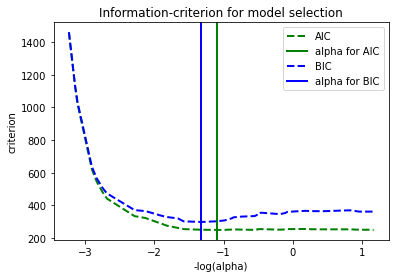

In [33]:
def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color = color, linewidth = 2, label = name)
    plt.axvline(-np.log10(alpha_), color = color, linewidth = 2, label = 'alpha for %s' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'green')
plot_ic_criterion(model_bic, 'BIC', 'blue')
plt.legend()
plt.title('Information-criterion for model selection')

## Analyze the final result

Finally, use the best value for the regularization parameter according to AIC and BIC, and compare $R^2$ and RMSE using train-test split. Compare with the baseline model.

Remember, you can find the Root Mean Squared Error (RMSE) by setting `squared=False` inside the function (see [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)), and the RMSE returns values that are in the same units as our target - so we can see how far off our predicted sale prices are in dollars.

In [34]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

In [39]:
# Split X_scaled and y into training and test sets
# Set random_state to 1
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 1)

# Code for baseline model
linreg_all = LinearRegression()
linreg_all.fit(X_train, y_train)

# Print R-Squared and RMSE
print('Traning R2:', linreg_all.score(X_train, y_train))
print('Test R2:', linreg_all.score(X_test, y_test))
print('Training RSME:', mean_squared_error(y_train, linreg_all.predict(X_train), squared = False))
print('Test RMSE:', mean_squared_error(y_test, linreg_all.predict(X_test), squared = False))

Traning R2: 0.7478270652928448
Test R2: 0.8120708166668682
Training RSME: 39424.15590381302
Test RMSE: 35519.17035590489


In [40]:
# Split df_inter and y into training and test sets
# Set random_state to 1
X_train, X_test, y_train, y_test = train_test_split(df_inter, y, random_state = 1)

# Code for lasso with alpha from AIC
lasso = Lasso(alpha = model_aic.alpha_)
lasso.fit(X_train, y_train)

# Print R-Squared and RMSE
print('Training R2:', lasso.score(X_train, y_train))
print('Test R2:', lasso.score(X_test, y_test))
print('Training RMSE:', mean_squared_error(y_train, lasso.predict(X_train), squared = False))
print('Test RMSE:', mean_squared_error(y_test, lasso.predict(X_test), squared = False))

Training R2: 0.844671499395537
Test R2: 0.8657420069305379
Training RMSE: 30941.3132234915
Test RMSE: 30021.734184476514


In [41]:
# Code for lasso with alpha from BIC
lasso = Lasso(alpha = model_bic.alpha_)
lasso.fit(X_train, y_train)

# Print R-Squared and RMSE
print('Training R2:', lasso.score(X_train, y_train))
print('Test R2:', lasso.score(X_test, y_test))
print('Training RMSE:', mean_squared_error(y_train, lasso.predict(X_train), squared = False))
print('Test RMSE:', mean_squared_error(y_test, lasso.predict(X_test), squared = False))

Training R2: 0.8446487101363189
Test R2: 0.8660207515757946
Training RMSE: 30943.582941357854
Test RMSE: 29990.55263037504


## Level up (Optional)

### Create a Lasso path

From this section, you know that when using Lasso, more parameters shrink to zero as your regularization parameter goes up. In Scikit-learn there is a function `lasso_path()` which visualizes the shrinkage of the coefficients while $alpha$ changes. Try this out yourself!

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py

### AIC and BIC for subset selection
This notebook shows how you can use AIC and BIC purely for feature selection. Try this code out on our Ames housing data!

https://xavierbourretsicotte.github.io/subset_selection.html

## Summary

Congratulations! You now know how to create better linear models and how to use AIC and BIC for both feature selection and to optimize your regularization parameter when performing Ridge and Lasso. 